In [1]:
import sys
import numpy as np
import os
from image_utils import standardize
from IOU_computations import *
from numpy import newaxis
import matplotlib.pyplot as plt
from shapeSorter import SimpleSegmentationDataset
# from unet_meli import UNet
# from unet_val import UNet

import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
from resunet_main_fin import predict,criterion
import torch.backends.cudnn as cudnn

/home/s161362/.conda/envs/env_dhi/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
!gpustat

coeus  Wed Apr 25 14:17:12 2018
[0] TITAN X (Pascal) | 58'C,   1 % | 11729 / 12189 MB | s161488(11715M)
[1] TITAN X (Pascal) | 70'C,   1 % | 11731 / 12189 MB | s161488(11717M)
[2] TITAN X (Pascal) | 71'C,  24 % | 11729 / 12189 MB | s161488(11715M)
[3] TITAN X (Pascal) | 65'C,   0 % | 10695 / 12189 MB | s161362(10685M)
[4] TITAN X (Pascal) | 64'C,   0 % | 11157 / 12189 MB | s161362(11147M)
[5] TITAN X (Pascal) | 71'C,   6 % | 11731 / 12189 MB | s161488(11717M)
[6] TITAN X (Pascal) | 36'C,   0 % |     0 / 12189 MB |
[7] TITAN X (Pascal) | 34'C,   2 % |     0 / 12189 MB |


In [3]:

INPUT_CHANNELS=3
NB_CLASSES=2
DEFAULT_LAYERS=3
DEFAULT_FEATURES_ROOT=32
DEFAULT_WIDTH_KERNEL=3


In [4]:
def plot_summary(predictions,labels,pansharp,batch_size,batch_number,prediction_path,display='all'):
    
    if display=='all':
        fig,axs=plt.subplots(3, batch_size,figsize=(8*batch_size,24))

        axs[0,0].set_title(str(batch_number)+' Pansharpened ', fontsize='large')
        axs[1,0].set_title(str(batch_number)+' Groundtruth ', fontsize='large')
        axs[2,0].set_title(str(batch_number)+' Predictions ', fontsize='large')


        for i in range(batch_size):

            axs[0,i].imshow(pansharp[i])
            plt.imsave(prediction_path+'_'+str(batch_number)+'_Pansharpened_'+str(i)+'.jpg',pansharp[i])
            axs[1,i].imshow(labels[i])
            plt.imsave(prediction_path+'_'+str(batch_number)+'_Groundtruth_'+str(i)+'.jpg',labels[i])
            axs[2,i].imshow(predictions[i])
            plt.imsave(prediction_path+'_'+str(batch_number)+'_Predictions_'+str(i)+'.jpg',predictions[i])
    
    else:
        fig,axs=plt.subplots(1, batch_size,figsize=(8*batch_size,24))
        axs[0].set_title(str(batch_number)+' Predictions ', fontsize='large')
        for i in range(batch_size):
            axs[i].imshow(predictions[i])
            plt.imsave(prediction_path+'_'+str(batch_number)+'_Predictions_'+str(i)+'.jpg',predictions[i])
        

    plt.show()



In [5]:
def generate_dataset(path_validation,validation_batch_size):
    val_generator=SimpleSegmentationDataset(120, 3, alpha =1.0,virtual_size=500)
    val_loader = DataLoader(val_generator, batch_size=validation_batch_size,shuffle=False, num_workers=1)
    
    return val_loader

In [8]:
def predict_pytorch_val(val_loader,number_iterations,restore_path,prediction_path,display,param=None):
    TMP_IOU=prediction_path+'TMP_IOU/'
    if not os.path.exists(TMP_IOU):
            os.makedirs(TMP_IOU)
    loss_fn=nn.CrossEntropyLoss()
    


    model=UNet(INPUT_CHANNELS,NB_CLASSES,depth=DEFAULT_LAYERS,n_features_zero=DEFAULT_FEATURES_ROOT,dropout=0,width_kernel=DEFAULT_WIDTH_KERNEL,distance_net=param)
    

        
    model.cuda()
    cudnn.benchmark = True
    model.load_state_dict(torch.load(restore_path))
    
    counter=0
    for i_batch,sample_batch in enumerate(val_loader):
        
        X_val=standardize(sample_batch['input'])       
        Y_val=sample_batch['groundtruth']

        predictions=[]
        for j in range(len(X_val)):
            X_val_j=X_val[j]
            X_val_j=X_val_j[newaxis,:,:,:]
            X_val_j=standardize(X_val_j)
            Y_val_j=Y_val[j]
            Y_val_j=Y_val_j[newaxis,:,:,:]
            
            X = Variable(X_val_j.float())
            X=X.permute(0,3,1,2).cuda()  
            Y = Variable(Y_val_j.float())
            Y=Y.cuda()  
            
            if param:
                _,predictions_i=predict(model,X,param)
            else:
                predictions_i=predict(model,X)
#             print(predictions_i)
            loss_i=criterion(Y,predictions_i)
            loss_i=loss_i.data[0]
            predictions_i=predictions_i.data.cpu().numpy()
            Y_val_j=np.asarray(Y_val_j)
            iou_acc_v,f1_v,iou_v=predict_score_batch(TMP_IOU,np.argmax(Y_val_j,3),np.argmax(predictions_i,3))
            print("Image {:d}, Validation IoU {:.4f}, Validation IoU_acc {:.4f}%,Validation F1 IoU {:.4f}%, loss {:.8f}".format(j,iou_v,iou_acc_v,f1_v,loss_i))
            predictions.append(predictions_i)
            
        predictions=np.squeeze(np.asarray(predictions))
        X_val=np.asarray(X_val)
        Y_val=np.asarray(Y_val)
        pansharp=X_val
#         pansharp=np.stack((X_val[:,:,:,5],X_val[:,:,:,3],X_val[:,:,:,2]),axis=3)
        plot_summary(np.argmax(predictions,3),np.argmax(Y_val,3),pansharp,len(X_val),counter,prediction_path,display)
        counter+=1
        if counter==number_iterations:
            break
            
        
        

SHAPE DIST
Image 0, Validation IoU 0.9397, Validation IoU_acc 100.0000%,Validation F1 IoU 18.1818%, loss 1.25949955
Image 1, Validation IoU 1.0000, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.00000000
Image 2, Validation IoU 0.9397, Validation IoU_acc 100.0000%,Validation F1 IoU 18.1818%, loss 1.25949955
Image 3, Validation IoU 0.9235, Validation IoU_acc 100.0000%,Validation F1 IoU 42.8571%, loss 0.63855058
Image 4, Validation IoU 0.9998, Validation IoU_acc 100.0000%,Validation F1 IoU 80.0000%, loss 0.00301313
Image 5, Validation IoU 1.0000, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.00000000
Image 6, Validation IoU 0.9397, Validation IoU_acc 100.0000%,Validation F1 IoU 18.1818%, loss 1.25949955
Image 7, Validation IoU 0.9397, Validation IoU_acc 100.0000%,Validation F1 IoU 18.1818%, loss 1.25949955
Image 8, Validation IoU 1.0000, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.00000000
Image 9, Validation IoU 0.9397, Validatio

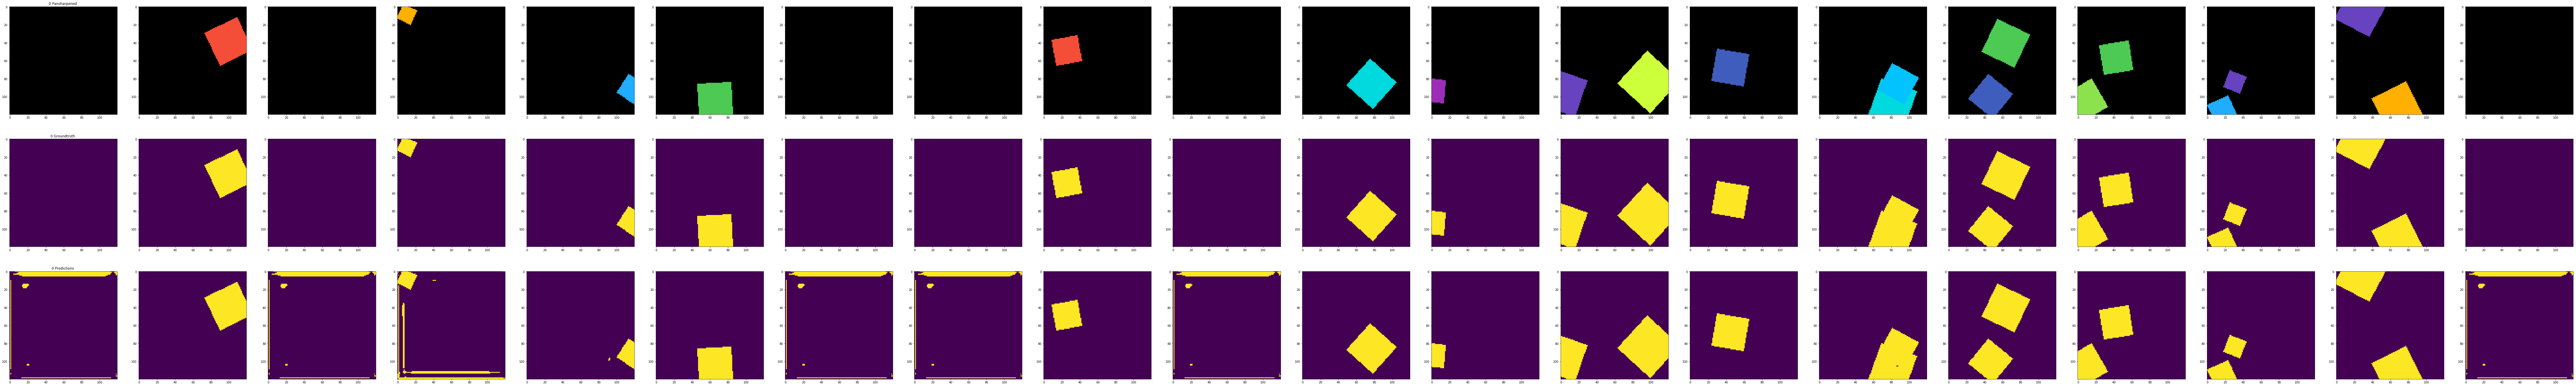

SHAPE NO  DIST
Image 0, Validation IoU 0.9724, Validation IoU_acc 100.0000%,Validation F1 IoU 16.6667%, loss 0.11292101
Image 1, Validation IoU 1.0000, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.00000000
Image 2, Validation IoU 0.9724, Validation IoU_acc 100.0000%,Validation F1 IoU 16.6667%, loss 0.11292101
Image 3, Validation IoU 0.8628, Validation IoU_acc 100.0000%,Validation F1 IoU 60.0000%, loss 0.05563309
Image 4, Validation IoU 1.0000, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.00000022
Image 5, Validation IoU 1.0000, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.00000000
Image 6, Validation IoU 0.9724, Validation IoU_acc 100.0000%,Validation F1 IoU 16.6667%, loss 0.11292101
Image 7, Validation IoU 0.9724, Validation IoU_acc 100.0000%,Validation F1 IoU 16.6667%, loss 0.11292101
Image 8, Validation IoU 1.0000, Validation IoU_acc 100.0000%,Validation F1 IoU 100.0000%, loss 0.00000000
Image 9, Validation IoU 0.9724, Vali

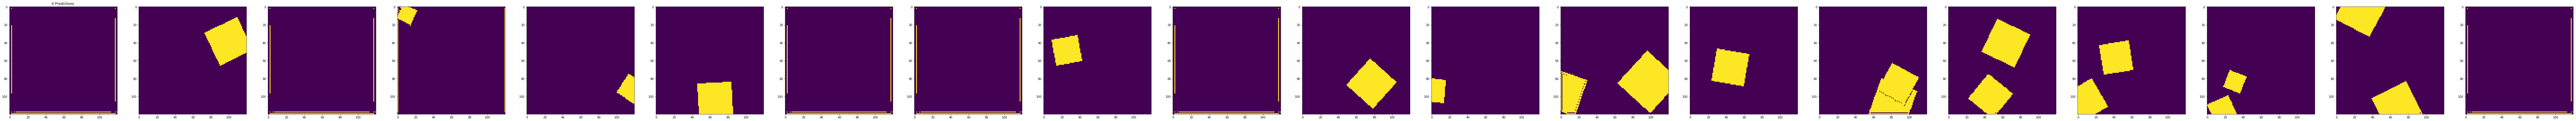

In [9]:
if __name__ == '__main__':
    
    
    
    root_folder = '../2_DATA_GHANA/DATASET/120_x_120_8_pansh/'
    
    validation_loader=generate_dataset(root_folder+'TEST/',20)



#     #####VAL########
#     from unet_val import UNet
#     prediction_path='VISUALIZATION_IMAGES/SHAPE_VAL/'

#     if not os.path.exists(prediction_path):
#             os.makedirs(prediction_path)


#     print('VAL SHAPE')
#     predict_pytorch_val(validation_loader,1,'MODEL_SHAPE_PYTORCH_VAL/pytorch_shape_valCP2600.pth',prediction_path,'all')
    
    

#     #####MELI########
#     from unet_meli import UNet
#     prediction_path='VISUALIZATION_IMAGES/SHAPE_MELI/'

#     if not os.path.exists(prediction_path):
#             os.makedirs(prediction_path)


#     print('MELI SHAPE')
#     predict_pytorch_val(validation_loader,1,'MODEL_SHAPE_PYTORCH_MELI/pytorch_shape_meliCP2600.pth',prediction_path,'no')



#     #####w3########
#     from unet_val_2 import UNet
#     prediction_path='VISUALIZATION_IMAGES/SHAPE_w_3/'

#     if not os.path.exists(prediction_path):
#             os.makedirs(prediction_path)


#     print('w3 SHAPE')
#     predict_pytorch_val(validation_loader,1,'MODEL_SHAPE_w3/pytorch_shape_w3CP7600.pth',prediction_path,'all',param=3)
    
    

#     #####w5########
 
#     prediction_path='VISUALIZATION_IMAGES/SHAPE_w_5/'

#     if not os.path.exists(prediction_path):
#             os.makedirs(prediction_path)


#     print('w5 SHAPE')
#     predict_pytorch_val(validation_loader,1,'MODEL_SHAPE_w5/pytorch_shape_w5CP7600.pth',prediction_path,'no',param=5)

#     #####w9########
 
#     prediction_path='VISUALIZATION_IMAGES/SHAPE_w_9/'

#     if not os.path.exists(prediction_path):
#             os.makedirs(prediction_path)


#     print('w9 SHAPE')
#     predict_pytorch_val(validation_loader,1,'MODEL_SHAPE_w9/pytorch_shape_w9CP7600.pth',prediction_path,'no',param=9)


# #   #####L3########
#     from unet_val_2 import UNet
#     prediction_path='VISUALIZATION_IMAGES/SHAPE_L3/'

#     if not os.path.exists(prediction_path):
#             os.makedirs(prediction_path)


#     print('L3')
#     predict_pytorch_val(validation_loader,1,'MODEL_SHAPE_L1/pytorch_shape_L1CP12400.pth',prediction_path,'all',param=3)
    
    

#     #####L2######
 
#     prediction_path='VISUALIZATION_IMAGES/SHAPE_L2/'

#     if not os.path.exists(prediction_path):
#             os.makedirs(prediction_path)


#     print('L2')
#     predict_pytorch_val(validation_loader,1,'MODEL_SHAPE_L2/pytorch_shape_L2CP12400.pth',prediction_path,'no',param=2)

#     #####L1########
#     prediction_path='VISUALIZATION_IMAGES/SHAPE_L1/'

#     if not os.path.exists(prediction_path):
#             os.makedirs(prediction_path)


#     print('L1')
#     predict_pytorch_val(validation_loader,1,'MODEL_SHAPE_L3/pytorch_shape_L3CP12400.pth',prediction_path,'no',param=1)

    ##MODEL DIST###
    from unet_val_2 import UNet
    prediction_path='VISUALIZATION_IMAGES/SHAPE_DIST/'

    if not os.path.exists(prediction_path):
            os.makedirs(prediction_path)


    print('SHAPE DIST')
    predict_pytorch_val(validation_loader,1,'MODEL_SHAPE_DIST/RESUNET_shape_dist_restoredCP14000.pth',prediction_path,'all',param=True)
    
     ##MODEL DIST###
    from unet_val_2 import UNet
    prediction_path='VISUALIZATION_IMAGES/SHAPE_NODIST/'

    if not os.path.exists(prediction_path):
            os.makedirs(prediction_path)


    print('SHAPE NO  DIST')
    predict_pytorch_val(validation_loader,1,'MODEL_SHAPE_NODIST/RESUNET_shape_nodistCP12000.pth',prediction_path,'no',param=False)
    
    
    